# Imports

In [1]:
# %pip uninstall "opencv-python-headless" --y

In [2]:
# %pip install pandas
# %pip install matplotlib
# %pip install opencv-python-headless
# %pip install scikit-image
# %pip install basic-image-eda
# %pip install seaborn
# %pip install torchvision
# %pip install sklearn
# %pip install pandas_profiling
# %pip install awswrangler
# %pip install ipywidgets

In [3]:
import os
import glob
import shutil
import time
import copy
import random

import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mp_image
import seaborn as sns

from IPython.display import Image, display

from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models

import torch
from torch.utils.data import DataLoader
from torch.utils.mobile_optimizer import optimize_for_mobile
import torch.nn as nn

from sklearn.metrics import confusion_matrix

import awswrangler as wr

# Data Load

In [4]:
s3_path = f's3://rubyhan-w210-datasets/full_data.csv'
full_df = wr.s3.read_csv(path=s3_path, index_col=0).rename(columns={'duplicated':'duplicate', 'class':'label'})

# ProfileReport(full_df)

In [5]:
full_df.head()

,image_id,diagnosis,age,sex,localization,source,severity,path,label,duplicate,dataset,split_1,split_2,split_3,label_1,label_2,label_3,split_4,split_5,split_6
0,fissure-2,eczema photos,0.0,unknown,unknown,dermnet,unknown,./Data/dermnet/train/Nail Fungus and other Nai...,Non-Cancerous Skin Condition,True,NaN,NaN,NaN,NaN,Non-Cancerous Skin Condition,Non-Cancerous Skin Condition,Non-Cancerous Skin Condition,NaN,NaN,NaN
1,id-reaction-10,eczema photos,0.0,unknown,unknown,dermnet,unknown,./Data/dermnet/train/Tinea Ringworm Candidiasi...,Non-Cancerous Skin Condition,True,NaN,NaN,NaN,NaN,Non-Cancerous Skin Condition,Non-Cancerous Skin Condition,Non-Cancerous Skin Condition,NaN,NaN,NaN
2,id-reaction-7,eczema photos,0.0,unknown,unknown,dermnet,unknown,./Data/dermnet/train/Tinea Ringworm Candidiasi...,Non-Cancerous Skin Condition,True,NaN,NaN,NaN,NaN,Non-Cancerous Skin Condition,Non-Cancerous Skin Condition,Non-Cancerous Skin Condition,NaN,NaN,NaN
3,fissure-5,eczema photos,0.0,unknown,unknown,dermnet,unknown,./Data/dermnet/train/Nail Fungus and other Nai...,Non-Cancerous Skin Condition,True,NaN,NaN,NaN,NaN,Non-Cancerous Skin Condition,Non-Cancerous Skin Condition,Non-Cancerous Skin Condition,NaN,NaN,NaN
4,id-reaction-1,eczema photos,0.0,unknown,unknown,dermnet,unknown,./Data/dermnet/train/Tinea Ringworm Candidiasi...,Non-Cancerous Skin Condition,True,NaN,NaN,NaN,NaN,Non-Cancerous Skin Condition,Non-Cancerous Skin Condition,Non-Cancerous Skin Condition,NaN,NaN,NaN


In [6]:
cd /home/studio-lab-user/teledermatologyAI_capstone

/home/studio-lab-user/teledermatologyAI_capstone


# Transforming Tabular to Folder Data Structure

In [7]:
# print(len(full_df[(full_df.source != 'ISIC_2020') & (full_df.dataset == 'train')]))
# print(len(full_df[(full_df.source != 'ISIC_2020') & (full_df.dataset == 'val')]))
# print(len(full_df[(full_df.source != 'ISIC_2020') & (full_df.dataset == 'test')]))

data_split = 'split_3'
data_dir = 'data_class_folder3'

print(len(full_df[(full_df.source != 'ISIC_2020') & (full_df[data_split] == 'train')]))
print(len(full_df[(full_df.source != 'ISIC_2020') & (full_df[data_split] == 'val')]))
print(len(full_df[(full_df.source != 'ISIC_2020') & (full_df[data_split] == 'test')]))

10418
2103
1393


In [8]:
# full_df[full_df.path.str.contains('acne-keloidalis-1.jpg')]

In [9]:
class_list = full_df[~full_df[data_split].isna()].label.unique().tolist()
# class_list.remove('Autoimmue Disorder')

!mkdir -p $data_dir/train $data_dir/val $data_dir/test
for label in class_list:
    !mkdir -p $data_dir/train/"$label" 
    !mkdir -p $data_dir/val/"$label" 
    !mkdir -p $data_dir/test/"$label"

In [10]:
for i, row in full_df.iterrows():
    try:
        shutil.copy(row.path, f'{data_dir}/{row[data_split]}/{row.label}')
    except FileNotFoundError as e:
        pass

In [11]:
# credits: https://github.com/yuliyabohdan/Skin-diseases-classification-Dermnet-/blob/main/skin_diseases_clas_ResNet50.ipynb

DIR = data_dir
DIR_TRAIN = f'{DIR}/train/'
DIR_VAL = f'{DIR}/val/'
DIR_TEST = f'{DIR}/test/' 

classes = sorted(os.listdir(DIR_TRAIN))
print(f'Data split: {DIR}')
print(f'Total classes: {len(classes)}')

# total train, val and test images
train_count = 0
val_count = 0
test_count = 0

classes_df = []
for _class in classes:
    class_dict = {}
    train_count += len(os.listdir(DIR_TRAIN + _class))
    val_count += len(os.listdir(DIR_VAL + _class))
    test_count += len(os.listdir(DIR_TEST + _class))
    class_dict.update({'Class': _class, 
                       'Train': len(os.listdir(DIR_TRAIN + _class)),
                       'Val': len(os.listdir(DIR_VAL + _class)),
                       'Test': len(os.listdir(DIR_TEST + _class)) })
    classes_df.append(class_dict)

print(f'Total num train images: {train_count}')
print(f'Total num val images: {val_count}')
print(f'Total num test images: {test_count}')
print(pd.DataFrame(classes_df))

Data split: data_class_folder3
Total classes: 5
Total num train images: 10418
Total num val images: 2103
Total num test images: 1393
                                               Class  Train  Val  Test
0                             Benign Marking or Mole   1871  392   246
1                       Non-Cancerous Skin Condition   2671  534   395
2                  Potentially Malignant Skin Tumors   2274  452   290
3  Toxin, Fungal, Bug, Viral, or Bacterial Infect...   2702  540   358
4                                       Unclassified    900  185   104


In [12]:
# map class labels to integer index

train_imgs = []
val_imgs = []
test_imgs = []

for _class in classes:
    
    for img in os.listdir(DIR_TRAIN + _class):
        train_imgs.append(f'{DIR_TRAIN}{_class}/{img}')
    
    for img in os.listdir(DIR_VAL + _class):
        val_imgs.append(f'{DIR_VAL}{_class}/{img}')
    
    for img in os.listdir(DIR_TEST + _class):
        test_imgs.append(f'{DIR_TEST}{_class}/{img}')

classToInt = {classes[i]: i for i in range(len(classes))}
intToClass = dict(map(reversed, classToInt.items()))

for k, v in classToInt.items():
    print(k, v)

Benign Marking or Mole 0
Non-Cancerous Skin Condition 1
Potentially Malignant Skin Tumors 2
Toxin, Fungal, Bug, Viral, or Bacterial Infections 3
Unclassified 4


In [13]:
train_lst = []
val_lst = []
for _class, _classInt in classToInt.items():
    for img in os.listdir(DIR_TRAIN + _class):
        train_lst.append(f'{_classInt}\t{_class}/{img}')
        
for _class, _classInt in classToInt.items():
    for img in os.listdir(DIR_VAL + _class):
        val_lst.append(f'{_classInt}\t{_class}/{img}')

In [14]:
print(len(train_lst))
print(len(val_lst))

10418
2103


In [15]:
# train_lst2 = [f'{i}\t{items}' for i, items in enumerate(train_lst)]
# val_lst2 = [f'{i}\t{items}' for i, items in enumerate(val_lst)]
# random.shuffle(train_lst2)
# random.shuffle(val_lst2)

# with open('train_lst.lst', 'w') as f:
#     for line in train_lst2:
#         f.write(f"{line}\n")
# with open('validation_lst.lst', 'w') as f:
#     for line in val_lst2:
#         f.write(f"{line}\n")

# Data Split/Transforms

In [16]:
train_dataset = ImageFolder(root = DIR_TRAIN, transform=transforms.Compose([
    transforms.RandomRotation([-8, +8]),                                           # if augmentation
    transforms.ColorJitter(brightness=0, contrast=0.4, saturation=0, hue=0),      # if augmentation
    transforms.RandomHorizontalFlip(),                                            # if augmentation
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.676, 0.542, 0.519], std=[0.290, 0.226, 0.237])
]))

valid_dataset = ImageFolder(root = DIR_VAL, transform=transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.676, 0.542, 0.519], std=[0.290, 0.226, 0.237])
]))

test_dataset = ImageFolder(root = DIR_TEST, transform=transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.676, 0.542, 0.519], std=[0.290, 0.226, 0.237])
]))

In [20]:
# test_size = int(0.5 * len(test_dataset))
# valid_size = len(test_dataset) - test_size
# valid_dataset, test_dataset = torch.utils.data.random_split(test_dataset, 
#                                                             [valid_size, test_size])

# Train/Val Data Loader

In [21]:
dataloaders_dict = {}
dataloaders_dict['train'] = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=24)
dataloaders_dict['val'] = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=24, drop_last=False)
dataloader_test = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=24, drop_last=False)

/home/studio-lab-user/.conda/envs/w210env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Modeling

In [22]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0


    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:               
                model.eval()   # Set model to evaluate mode
                #update_bn_stats(model=model, data_loader=dataloaders[phase])  # if update_bn_stats
                
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                      # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

               # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
   
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [23]:
def test_model(model, dl, normalize=True):
    model.eval()
    true_labels = []
    predictions = []
    total = 0
    num_correct = 0
    with torch.no_grad():
        for images, labels in dl:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs.data,-1)        
            true_labels.append(labels.cpu().numpy())
            predictions.append(predicted.cpu().numpy())
            total += labels.size(0)
            num_correct += (predicted == labels).sum()
        print(f'Test Accuracy of the model: {float(num_correct)/float(total)*100:.2f}')    
        true_labels = np.hstack(true_labels)
        predictions = np.hstack(predictions)

    return true_labels, predictions

In [24]:
# x, y - find the img from class x labelled as class y 
def test(model, dl, x, y, normalize=True):
    model.eval()
    true_labels = []
    predictions = []
    images_list = []

    with torch.no_grad():
        for images, labels in dl:
            images_list.append(images.cpu().numpy())
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs.data,-1)        
            true_labels.append(labels.cpu().numpy())
            predictions.append(predicted.cpu().numpy())
    
    for n in range(60):
        for i in range(32):
            if (true_labels[n][i] == x)  & (predictions[n][i] == y):
                #inv_tensor = inv_normalize(image_list[n][i]])
                plt.imshow(np.transpose(images_list[n][i], (1, 2, 0)))
                plt.show()

In [26]:
# Number of epochs to train for
num_epochs = 5 #100

model = models.resnet50(weights='DEFAULT')
model.fc = nn.Linear(2048, len(classes), bias=True)

# Detect if we have a GPU available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.0001
)
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

cuda:0


In [27]:
# Train and evaluate
model, hist = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/4
----------
train Loss: 1.0774 Acc: 0.5627
val Loss: 0.9713 Acc: 0.6115

Epoch 1/4
----------
train Loss: 0.8190 Acc: 0.6782
val Loss: 0.8595 Acc: 0.6671

Epoch 2/4
----------
train Loss: 0.6575 Acc: 0.7498
val Loss: 0.8314 Acc: 0.6828

Epoch 3/4
----------
train Loss: 0.5122 Acc: 0.8063
val Loss: 0.8125 Acc: 0.7066

Epoch 4/4
----------
train Loss: 0.3838 Acc: 0.8613
val Loss: 0.8755 Acc: 0.6904

Training complete in 10m 11s
Best val Acc: 0.706610


In [28]:
model_name = f'{data_split}_resnet50'
torch.save(model, f'model/{model_name}.pt')

In [29]:
model = torch.load(f'model/{model_name}.pt')

Test Accuracy of the model: 70.28


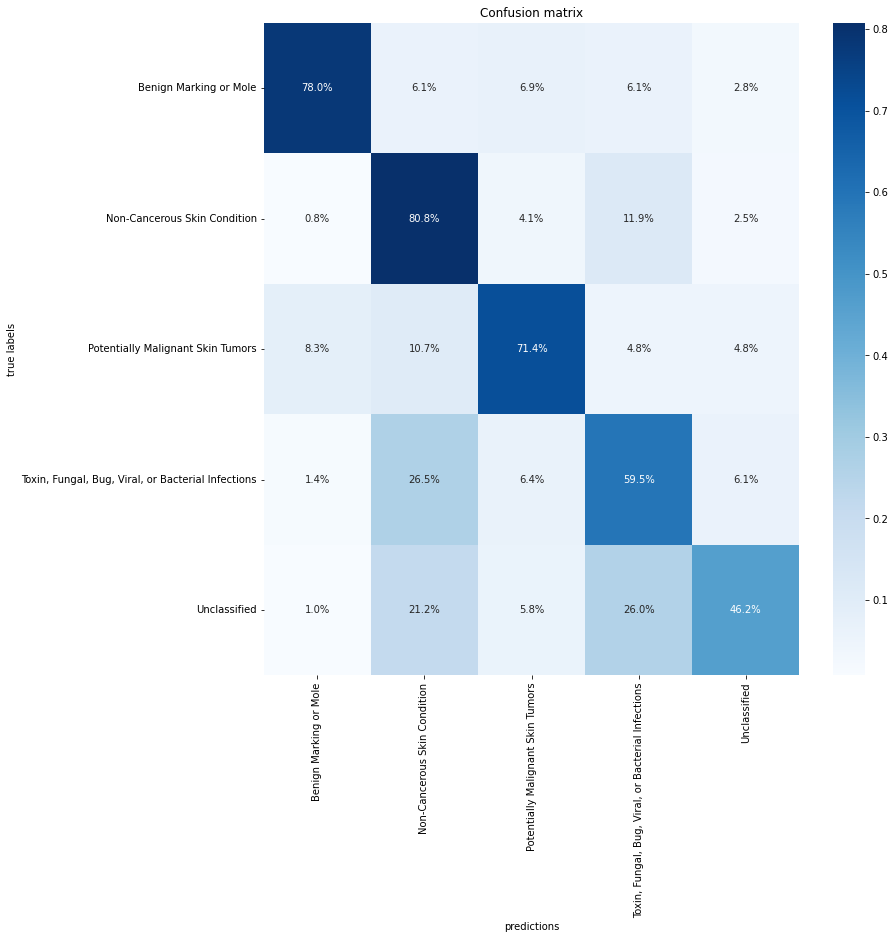

In [30]:
true_labels, predictions = test_model(model, dataloader_test, normalize=True)
c_matrix = confusion_matrix(true_labels, predictions, normalize='true')
plt.figure(figsize=(12, 12))
plt.title("Confusion matrix")
sns.heatmap(c_matrix, cmap='Blues', annot=True, xticklabels=classes, yticklabels=classes, fmt='.1%', cbar=True)
plt.xlabel('predictions')
plt.ylabel('true labels')
plt.show()

In [31]:
# # False prediction
# test(model, dataloader_test, 2, 0) #(potentially malignant skin tumors, non-cancerous skin condition)

In [32]:
# # Correct prediction of autoimmune disorder
# test(model, dataloader_test, 3, 3)

In [33]:
# # Trace model

# # must be the same size a minibatch with 1 example image
# example = torch.rand(1, 3, 224, 224)

# # move model back to cpu, do tracing, and optimize
# model_conv = model.to('cpu')
# traced_script_module = torch.jit.trace(model_conv, example)
# torchscript_model_optimized = optimize_for_mobile(traced_script_module)

# # save optimized model for mobile
# PATH = f'model/{model_name}_traced.pt'
# torchscript_model_optimized.save(PATH)

# Conversion from PyTorch to CoreML
https://github.com/vincentfpgarcia/from-pytorch-to-coreml/blob/master/step6_part1.md

In [46]:
import coremltools as ct
from coremltools.converters import ClassifierConfig

classifier_config = ClassifierConfig(class_labels=class_list)

model = torch.load(f'model/{model_name}.pt')

# Create dummy input
dummy_input = torch.rand(1, 3, 224, 224)

model_conv = model.to('cpu')

# Trace the model
traced_model = torch.jit.trace(model_conv, dummy_input)

# Create the input image type
input_image = ct.ImageType(name="my_input", shape=(1, 3, 224, 224), scale=1/255)

# Convert the model
coreml_model = ct.convert(traced_model, inputs=[input_image], classifier_config=classifier_config)

# Modify the output's name to "my_output" in the spec
spec = coreml_model.get_spec()
ct.utils.rename_feature(spec, "var_840", "my_output")

# Re-create the model from the updated spec
coreml_model_updated = ct.models.MLModel(spec)

# Save the CoreML model
coremlmodel_name = 'skindiseases5'
coreml_model_updated.save(f'model/{coremlmodel_name}.mlmodel')

# Load the CoreML model
model =  ct.models.MLModel(f'model/{coremlmodel_name}.mlmodel')

# Display its specifications
print()
print(model)

from PIL import Image

# classes
classes = ['Benign Marking or Mole',
           'Non-Cancerous Skin Condition',
           'Potentially Malignant Skin Tumors', 
           'Toxin, Fungal, Bug, Viral, or Bacterial Infections',
           'Unclassified']

# Load the test image
image = Image.open('inference/Potentially Malignant Skin Tumors/melanoma.jpeg')

# Prediction vector as a numpy array
pred = model.predict({'my_input': image.resize((224, 224))})
pred = pred['my_output']
pred = pred.squeeze()

# Display the most probable class
idx = pred.argmax()
print('Predicted class : %d (%s)' % (idx, classes[idx]))
pred['classLabel']

Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 455/455 [00:02<00:00, 173.46 ops/s] 



input {
  name: "my_input"
  type {
    imageType {
      width: 224
      height: 224
      colorSpace: RGB
    }
  }
}
output {
  name: "my_output"
  type {
    dictionaryType {
      stringKeyType {
      }
    }
  }
}
output {
  name: "classLabel"
  type {
    stringType {
    }
  }
}
predictedFeatureName: "classLabel"
predictedProbabilitiesName: "my_output"
metadata {
  userDefined {
    key: "com.github.apple.coremltools.source"
    value: "torch==1.12.1+cu102"
  }
  userDefined {
    key: "com.github.apple.coremltools.version"
    value: "6.0"
  }
}



Exception: Model prediction is only supported on macOS version 10.13 or later.

# Inference

In [ ]:
inference_dataset = ImageFolder(root = 'inference/', transform=transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.676, 0.542, 0.519], std=[0.290, 0.226, 0.237])
]))

dataloader_inference = DataLoader(inference_dataset, batch_size=1, 
                                  shuffle=False, num_workers=1, drop_last=False)

def inference_model(model, dl, normalize=True):
    model.eval()
    true_labels = []
    predictions = []
    total = 0
    num_correct = 0
    # device = torch.device('cpu')
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    with torch.no_grad():
        for images, labels in dl:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs.data,-1)        
            true_labels.append(labels.cpu().numpy())
            predictions.append(predicted.cpu().numpy())
            total += labels.size(0)
            num_correct += (predicted == labels).sum()
        print(f'Inference Accuracy of the model: {float(num_correct)/float(total)*100:.2f}')    
        true_labels = np.hstack(true_labels)
        predictions = np.hstack(predictions)

    return true_labels, predictions

In [ ]:
# model = torch.jit.load(f'model/{model_name}_traced.pt')
model = torch.load(f'model/{model_name}.pt')
true_labels, predictions = inference_model(model, dataloader_inference, normalize=True)

In [ ]:
true_labels

In [ ]:
predictions

In [ ]:
# !tar -czf model/model.tar.gz model/merged_resnet50.pt

In [ ]:
# !aws s3 cp model/model.tar.gz s3://rubyhan-w210-datasets/model/